Creating wildfire CHM comparison visualization...
------------------------------------------------------------

LOADING CHM DATA

Loading Palisades Fire CHMs...
Loading Eaton Fire CHMs...


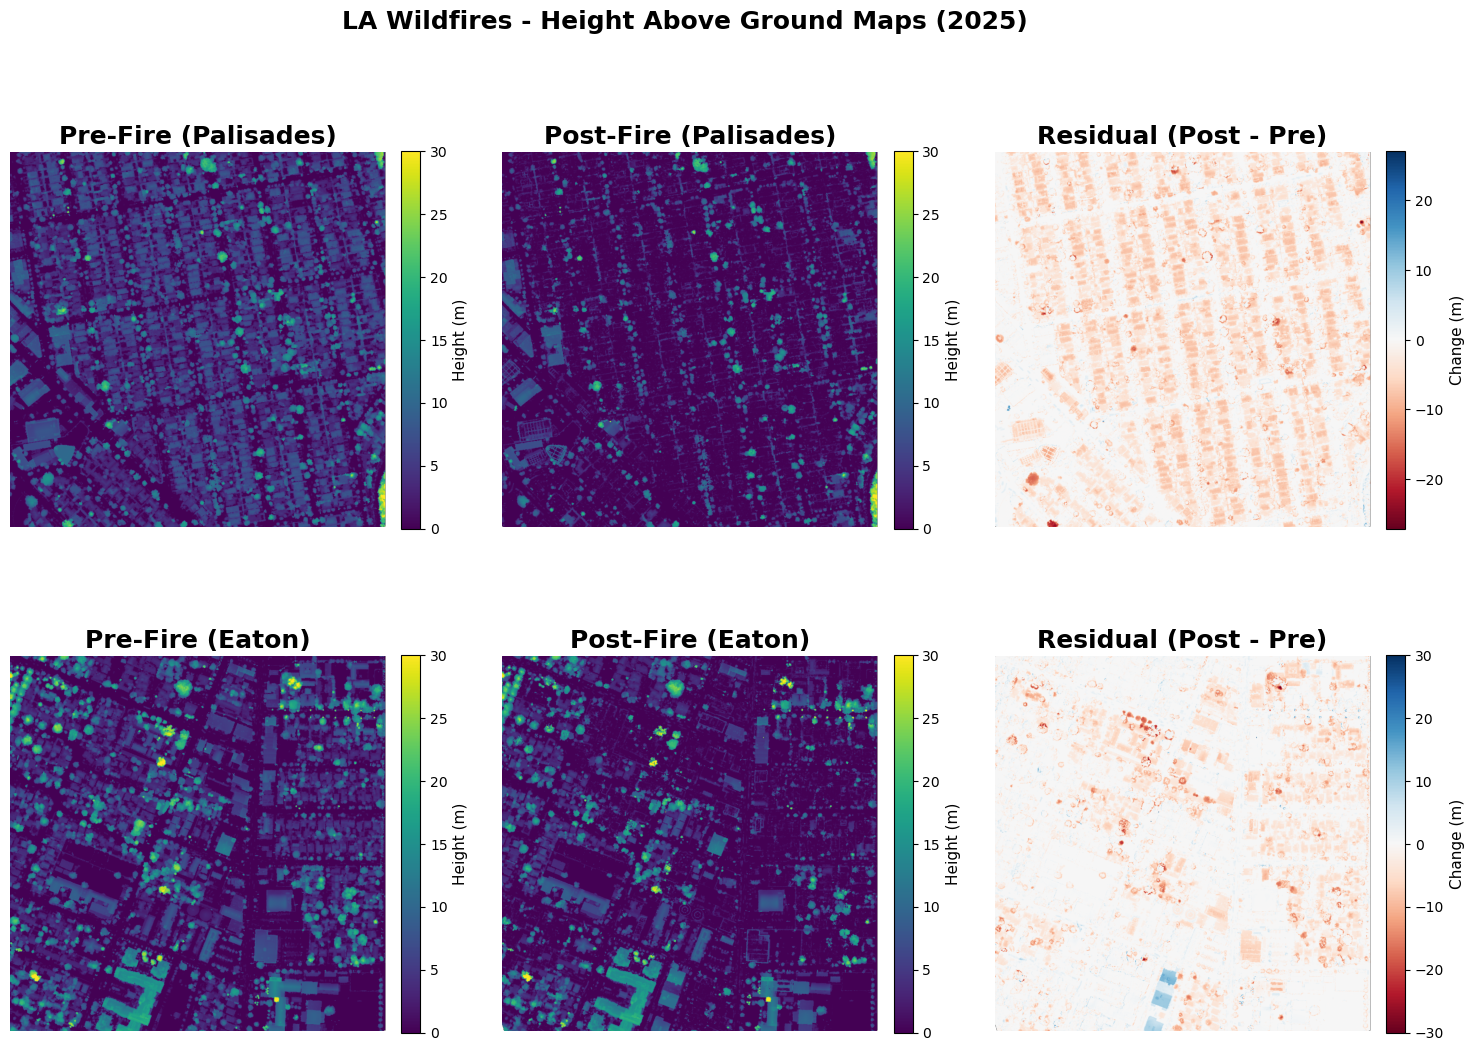

In [2]:
"""
Wildfire Canopy Height Model Comparison
Creates a 2x3 panel visualization comparing pre-fire, post-fire, and residual CHMs
for the Palisades and Eaton fires in Southern California (2025)

Uses rioxarray for:
- Loading rasters directly from HTTPS URLs (works great with COGs)
- Aligning/reprojecting pre-fire rasters to match post-fire rasters
- Handling CRS, extent, and resolution differences automatically
"""

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm
import rioxarray

plt.style.use('default')

# =============================================================================
# URLs to GeoTIFF files
# Replace these with your actual HTTPS URLs to the COG files
# =============================================================================

palisades_urls = {
    'pre': 'https://scil-data.sdsc.edu/data/nasa-werk/CA_LosAngeles_1_B23/USGS_LPC_CA_LosAngeles_B23_11SLT035900376800_topographic_cog_1m.tif',
    'post': 'https://scil-data.sdsc.edu/data/nasa-werk/CA_LAPostWildfire_Palisades_C25/USGS_LPC_CA_2025LosAngelesPostWildfire_C25_11SLT003592037680_topographic_cog_1m.tif',
}

eaton_urls = {
    'pre': 'https://scil-data.sdsc.edu/data/nasa-werk/CA_LosAngeles_1_B23/USGS_LPC_CA_LosAngeles_B23_11SLT039500378300_topographic_cog_1m.tif',
    'post': 'https://scil-data.sdsc.edu/data/nasa-werk/CA_LAPostWildfire_Eaton_C25/USGS_LPC_CA_2025LosAngelesPostWildfire_C25_11SLT003952037830_topographic_cog_1m.tif',
}


def load_and_align_chms(pre_url, post_url, chm_band=3, resampling=1):
    """
    Load pre-fire and post-fire CHMs from URLs, align pre to post, and compute residual.
    
    The post-fire raster is used as the template, meaning the pre-fire raster will be
    reprojected/resampled to match the post-fire raster's:
    - Coordinate Reference System (CRS)
    - Spatial extent (bounds)
    - Resolution (pixel size)
    - Grid alignment
    
    Parameters:
    -----------
    pre_url : str
        HTTPS URL to pre-fire multi-band raster (COG recommended)
    post_url : str
        HTTPS URL to post-fire multi-band raster (used as alignment template)
    chm_band : int
        Band number for CHM (1-indexed, default=3 for 3rd band)
    resampling : int
        Resampling method (0=nearest, 1=bilinear, 2=cubic, etc.)
    
    Returns:
    --------
    tuple : (pre_array, post_array, residual_array) as numpy arrays
    """
    # Open post-fire raster (this is our template)
    post_full = rioxarray.open_rasterio(post_url)
    post_chm = post_full.sel(band=chm_band)
    
    # Open pre-fire raster
    pre_full = rioxarray.open_rasterio(pre_url)
    pre_chm = pre_full.sel(band=chm_band)
    
    # Align pre-fire to post-fire template
    # reproject_match handles: CRS, extent, resolution, grid alignment
    pre_aligned = pre_chm.rio.reproject_match(
        post_chm,
        resampling=resampling
    )
    
    # Mask nodata and unrealistic values
    pre_masked = pre_aligned.where(pre_aligned > -10).where(pre_aligned < 100)
    post_masked = post_chm.where(post_chm > -10).where(post_chm < 100)
    
    # Compute residual (post - pre)
    residual = post_masked - pre_masked
    
    return pre_masked.values, post_masked.values, residual.values


def create_fire_comparison_panel():
    """
    Create 2x3 panel comparing pre-fire, post-fire, and residual CHMs
    for Palisades and Eaton fires.
    """
    print("\n" + "="*60)
    print("LOADING CHM DATA")
    print("="*60)
    
    # Load data for both fires
    print("\nLoading Palisades Fire CHMs...")
    palisades_pre, palisades_post, palisades_residual = load_and_align_chms(
        pre_url=palisades_urls['pre'],
        post_url=palisades_urls['post'],
        chm_band=3
    )
    
    print("Loading Eaton Fire CHMs...")
    eaton_pre, eaton_post, eaton_residual = load_and_align_chms(
        pre_url=eaton_urls['pre'],
        post_url=eaton_urls['post'],
        chm_band=3
    )
    
    # Create figure with 2 rows, 3 columns
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle('LA Wildfires - Height Above Ground Maps (2025)', 
                 fontsize=18, fontweight='bold', y=0.98)
    
    # Define consistent color limits for CHM (pre and post)
    chm_vmin, chm_vmax = 0, 30  # Typical canopy height range in meters
    
    # Row 1: Palisades Fire
    # Pre-fire CHM
    im1 = axes[0, 0].imshow(palisades_pre, cmap='viridis', vmin=chm_vmin, vmax=chm_vmax)
    axes[0, 0].set_title('Pre-Fire (Palisades)', fontsize=18, fontweight='bold')
    axes[0, 0].set_ylabel('Palisades Fire', fontsize=18, fontweight='bold', rotation=90, labelpad=10)
    axes[0, 0].axis('off')
    cbar1 = plt.colorbar(im1, ax=axes[0, 0], fraction=0.046, pad=0.04)
    cbar1.set_label('Height (m)', fontsize=11)
    
    # Post-fire CHM
    im2 = axes[0, 1].imshow(palisades_post, cmap='viridis', vmin=chm_vmin, vmax=chm_vmax)
    axes[0, 1].set_title('Post-Fire (Palisades)', fontsize=18, fontweight='bold')
    axes[0, 1].axis('off')
    cbar2 = plt.colorbar(im2, ax=axes[0, 1], fraction=0.046, pad=0.04)
    cbar2.set_label('Height (m)', fontsize=11)
    
    # Residual CHM (Post - Pre)
    residual_abs_max = np.nanmax(np.abs(palisades_residual))
    residual_limit = min(residual_abs_max, 30)  # Cap at 30m for better visualization
    norm = TwoSlopeNorm(vmin=-residual_limit, vcenter=0, vmax=residual_limit)
    im3 = axes[0, 2].imshow(palisades_residual, cmap='RdBu', norm=norm)
    axes[0, 2].set_title('Residual (Post - Pre)', fontsize=18, fontweight='bold')
    axes[0, 2].axis('off')
    cbar3 = plt.colorbar(im3, ax=axes[0, 2], fraction=0.046, pad=0.04)
    cbar3.set_label('Change (m)', fontsize=11)
    
    # Row 2: Eaton Fire
    # Pre-fire CHM
    im4 = axes[1, 0].imshow(eaton_pre, cmap='viridis', vmin=chm_vmin, vmax=chm_vmax)
    axes[1, 0].set_title('Pre-Fire (Eaton)', fontsize=18, fontweight='bold')
    axes[1, 0].set_ylabel('Eaton Fire', fontsize=18, fontweight='bold', rotation=90, labelpad=10)
    axes[1, 0].axis('off')
    cbar4 = plt.colorbar(im4, ax=axes[1, 0], fraction=0.046, pad=0.04)
    cbar4.set_label('Height (m)', fontsize=11)
    
    # Post-fire CHM
    im5 = axes[1, 1].imshow(eaton_post, cmap='viridis', vmin=chm_vmin, vmax=chm_vmax)
    axes[1, 1].set_title('Post-Fire (Eaton)', fontsize=18, fontweight='bold')
    axes[1, 1].axis('off')
    cbar5 = plt.colorbar(im5, ax=axes[1, 1], fraction=0.046, pad=0.04)
    cbar5.set_label('Height (m)', fontsize=11)
    
    # Residual CHM (Post - Pre)
    residual_abs_max = np.nanmax(np.abs(eaton_residual))
    residual_limit = min(residual_abs_max, 30)
    norm = TwoSlopeNorm(vmin=-residual_limit, vcenter=0, vmax=residual_limit)
    im6 = axes[1, 2].imshow(eaton_residual, cmap='RdBu', norm=norm)
    axes[1, 2].set_title('Residual (Post - Pre)', fontsize=18, fontweight='bold')
    axes[1, 2].axis('off')
    cbar6 = plt.colorbar(im6, ax=axes[1, 2], fraction=0.046, pad=0.04)
    cbar6.set_label('Change (m)', fontsize=11)

    plt.show()


if __name__ == "__main__":
    print("Creating wildfire CHM comparison visualization...")
    print("-" * 60)
    create_fire_comparison_panel()